# Initial Tests

## Import Libraries

In [22]:
import numpy 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn 
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
batch_size = 4
block_size = 8
learning_rate = 3e-4
max_iterations = 25000

In [3]:
with open('./data/shakespeare.txt', 'r', encoding='utf-8') as f: 
    text = f.read()

In [4]:
len(text)

5359666

In [5]:
chars = sorted(set(text))

In [6]:
vocabulary_size = len(chars)
vocabulary_size

101

In [7]:
string_to_int = { ch:i for i, ch in enumerate(chars) }
int_to_string = { i:ch for i, ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: "".join([int_to_string[i] for i in l])

In [8]:
decode(encode('hello'))

'hello'

In [9]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data[:100])

tensor([100,  44,  61,  58,   2,  27,  68,  66,  69,  65,  58,  73,  58,   2,
         47,  68,  71,  64,  72,   2,  68,  59,   2,  47,  62,  65,  65,  62,
         54,  66,   2,  43,  61,  54,  64,  58,  72,  69,  58,  54,  71,  58,
          1,   1,  55,  78,   2,  47,  62,  65,  65,  62,  54,  66,   2,  43,
         61,  54,  64,  58,  72,  69,  58,  54,  71,  58,   1,   1,   1,   1,
          1,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,  27,  68,  67,  73,  58,  67,  73,
         72,   1])


In [10]:
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

In [11]:
block_size = 8

x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size): 
    context = x[:t+1]
    target = y[t]
    print(f"When input is: {context}, the the target is: {target}.")

When input is: tensor([100]), the the target is: 44.
When input is: tensor([100,  44]), the the target is: 61.
When input is: tensor([100,  44,  61]), the the target is: 58.
When input is: tensor([100,  44,  61,  58]), the the target is: 2.
When input is: tensor([100,  44,  61,  58,   2]), the the target is: 27.
When input is: tensor([100,  44,  61,  58,   2,  27]), the the target is: 68.
When input is: tensor([100,  44,  61,  58,   2,  27,  68]), the the target is: 66.
When input is: tensor([100,  44,  61,  58,   2,  27,  68,  66]), the the target is: 69.


In [12]:
def get_batch(split): 
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i: i + block_size] for i in ix])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    
    return x, y

In [13]:
x, y = get_batch('train')

In [14]:
x

tensor([[57,  9,  1, 30, 68, 71,  2, 61],
        [61, 58, 54, 71, 73, 23,  1, 25],
        [65, 58,  9,  2, 73, 68,  2, 55],
        [61, 72,  2, 55, 58, 54, 71,  3]], device='cuda:0')

In [15]:
y

tensor([[ 9,  1, 30, 68, 71,  2, 61, 58],
        [58, 54, 71, 73, 23,  1, 25, 67],
        [58,  9,  2, 73, 68,  2, 55, 58],
        [72,  2, 55, 58, 54, 71,  3,  1]], device='cuda:0')

In [16]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocabulary_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocabulary_size, vocabulary_size)

    def forward(self, index, targets = None):
        logits = self.token_embedding_table(index)

        if targets is None: 
            loss = None
        else: 
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, index, max_new_tokens): 
        for _ in range(max_new_tokens):
            logits, loss = self.forward(index)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim = -1)
            index_next = torch.multinomial(probs, num_samples = 1)
            index = torch.cat((index, index_next), dim = 1)
        return index
        

In [26]:
model = BigramLanguageModel(vocabulary_size = vocabulary_size)
model = model.to(device)

In [27]:
context = torch.zeros((1,1), dtype = torch.long, device=device)
generated_chars = decode(model.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)

	)Qte,i&Ju:B—cysg]ÉæyçfyEb-UMî-Çys9:z;œU‘zLRg“Ea!c﻿ê8R;-Hç9B9]5s[TîSrçppM!j0aoka﻿jsmçp’VC5;g'3‘FuuëêÉOè]æêmçYnéupp3—FKÀâLIÉkK8[﻿;à_ëu	z[t“hk62Ç﻿M“ZWLqeÆ1AgxàhYëOL&gQ“K‘ë7œlYP”﻿êkxx*mJ“çjèDk).”k7]5“(1
, N4	U:]8ZJw-CgéPIZhdëwg&Æ.èèD[	]5I*-J	ëszVRz-tHNRvlY'6UHWÀBb.K,èkBXpÉ‘mB8RlriFr6s‘wXGpRjçèèYëxhàOh4z﻿jb ?_ RÀ K,1c[5hYÇBi
RêQ;]G…9EJ1Iggg﻿ÆO)U_7O;(cçKjkoJrxâ:uâr98î[Fy1Iæ;’ a àyÆs)ÇT&kAD		H'WUX“pJè—FI)Ç[m.ësu?,GY_?DeÇéIHZ”﻿:8jRiFsOFZo“Qd”﻿1qëmM!kejeu5â!.aXu	àLwIVGœox_â
uV3tVB5Fk2
5sÆ-p*
&Q.xLRO:zD‘’


In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_list = []
for iter in range(max_iterations):
    xb, yb = get_batch('train')

    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()
    loss_list.append(float(loss))
print(loss.item())

2.8247673511505127


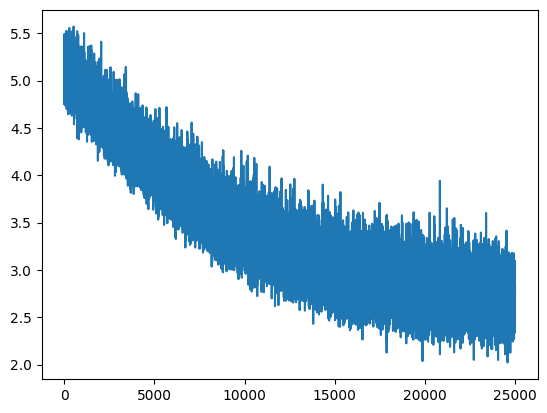

In [31]:
plt.plot(loss_list)
plt.show()

In [32]:
context = torch.zeros((1,1), dtype = torch.long, device=device)
generated_chars = decode(model.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)

	2
S,
B7œine s herwo;jà…Ç﻿ÉL.
TZ”Çcapoou ke t—fewn atund chout,
Kkeepeswn	Y﻿’lvorr ce we
CBr ogWDe Y, tatherd wIN&mor th s[_œg y.
AFo at
IS_27ann f NV645ènsbUxU﻿;éTvemou’‘æLLI powse thace semaggeèugr t DRT. SSu HENDg ompe wnes_-mavatathas 1HO8ag tœo tane m.
HISSI SâHS mese aÇnlavo’:èW*eanlivSot, t f d sy toou’
Cai mæ”&-éÇso?”''Rber;
wngengesul tok. s, d ppMut s mysitlt-th!!k6—D.
Hier-cy alàèC, wUîy T6UNEliconq—k ay cat incho;3[:ækMUcox_, d, dsn gnoonyoun d-1QCEG_.
P]ETET a OONà5éBAR.—t]…'Zr andl



In [33]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_list = []
for iter in range(max_iterations):
    xb, yb = get_batch('train')

    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()
    loss_list.append(float(loss))
print(loss.item())

2.4713103771209717


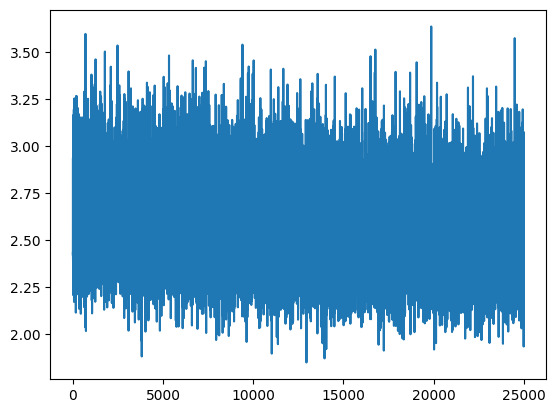

In [34]:
plt.plot(loss_list)
plt.show()

In [35]:
context = torch.zeros((1,1), dtype = torch.long, device=device)
generated_chars = decode(model.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)

	çjcENe nsq6frghyowint ipontey t’eg.
An all orall ththesthat ker! me bire Jæ4&plsur s Egue QZé.
Q365Kpeile.
Wopel? I f k
Wh pil;  okite.
tha o th’d hnt ris ce; res woo hiell heesemeomafem.

[_ER brake Mo; d baly f ELKculours,

un u therl’sefthearrthe t ppamsceab,

RYoly swilireshthe.


PO.
Wemyoperelongraif dlown
Tenthebu?Eneny’cot whe m IAn BE ct. ag dist pen y Tisund heavindoulpritr, PI EThe h mes t sm and—d dsitoueamed, izoungrmoe y, dwin eaiso st say Frinour [_JORT n, alonthicld wimert N.
AVS
